In [1]:
import csv
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sys.path.append('../utils')
from utils_dataset import dataset_structure
from utils_dataset import feature_names
from utils_dataset import label_names
from utils_plots import stamps_plot

In [3]:
# Dataset is loaded
with open('../dataset/td_ztf_stamp_17_06_20.pkl', 'rb') as f:
    data = pickle.load(f)

# Inner structure of dataset
dataset_structure(data)

-Train:
	-images    N=72710     Type:ndarray	-->	Type:ndarray   Shape:(63, 63, 3)
	-labels    N=72710     Type:ndarray	-->	Type:int64     Shape:Non-ndarray
	-features  N=72710     Type:ndarray	-->	Type:ndarray   Shape:(26,)     
-Validation:
	-images    N=500       Type:ndarray	-->	Type:ndarray   Shape:(63, 63, 3)
	-labels    N=500       Type:ndarray	-->	Type:int64     Shape:Non-ndarray
	-features  N=500       Type:ndarray	-->	Type:ndarray   Shape:(26,)     
-Test:
	-images    N=500       Type:ndarray	-->	Type:ndarray   Shape:(63, 63, 3)
	-labels    N=500       Type:ndarray	-->	Type:int64     Shape:Non-ndarray
	-features  N=500       Type:ndarray	-->	Type:ndarray   Shape:(26,)     


Label: Bogus


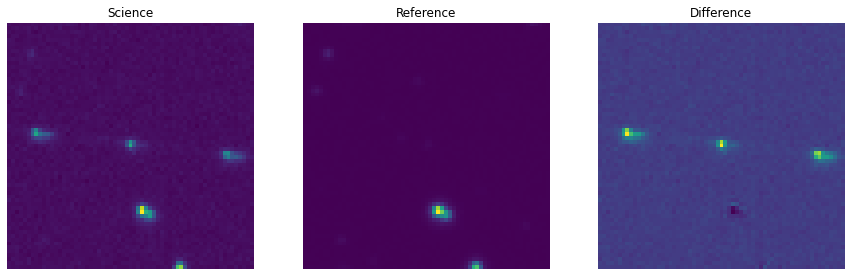

,Feature,Value
0,sgscore_1,-0.64196
1,sgscore_2,1.144819
2,sgscore_3,-0.8268
3,distpsnr_1,0.0
4,distpsnr_2,-0.34237
5,distpsnr_3,-1.469279
6,isdiffpos,-1.594562
7,fwhm,-0.911407
8,magpsf,-0.968328
9,sigmapsf,-1.156865


In [4]:
stamps_plot(data, 'Train', 11)

In [5]:
# Reduced dataset is loaded
#with open('../dataset/dataset_21.pkl', 'rb') as f:
#    data_red = pickle.load(f)

# Inner structure of dataset
#dataset_structure(data_red)

In [6]:
#stamps_plot(data_red, 'Train', 11)